In [23]:
import pandas as pd
import numpy as np
import numpy.linalg as la
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.base import clone
import timeit
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings

In [24]:
def pca(F, X):
    n, d = X.shape
    mu = np.zeros((d, 1))
    Z = np.zeros((d, F))
    for i in range(d):
        mu[i] = (1. / n) * np.sum(X[:, [i]])
    X = X - mu.T
    U, s, Vt = la.svd(X, False)
    g = s[:F]
    for i in range(F):
        g[i] = 1. / g[i]
    W = Vt[:F]
    Z = np.dot(W.T, np.diag(g))
    return (mu, Z)

def pca_proj(X,mu,Z):
    n, d = X.shape
    X = X - mu.T
    return np.dot(X, Z)

In [25]:
def k_fold(k, model, f, X, y, error_type="mse"):
    n, d = X.shape
    z = np.zeros((k, 1))
    for i in range(k):
        T = list(range(int((i * n) / k), int((n * (i + 1) / k))))
        S = [j for j in range(n) if j not in T]
        curr_model = clone(model)

        training_mu, training_Z = pca(f, X[S])
        training_X = pca_proj(X[S], training_mu, training_Z)

        curr_model.fit(training_X, y[S])

        test_X = pca_proj(X[T], training_mu, training_Z)

        # y[T] will be len(T) by 1
        # X[T] will be len(T) by d
        if error_type == "mse":
            z[i] = (1. / len(T)) * np.sum((y[T] - curr_model.predict(test_X)) ** 2)
        elif error_type == "log_mse":
            z[i] = (1. / len(T)) * np.sum((np.log(y[T] + 1) - np.log(curr_model.predict(test_X) + 1)) ** 2)
    return z

In [26]:
def bootstrapping(B, model, f, X, y, error_type="mse"):
    n, d = X.shape
    z = np.zeros((B, 1))
    for i in range(B):
        u = np.random.choice(n, n, replace=True)
        S = np.unique(u)
        T = np.setdiff1d(np.arange(n), S, assume_unique=True)
        curr_model = clone(model)

        training_mu, training_Z = pca(f, X[u])
        training_X = pca_proj(X[u], training_mu, training_Z)

        curr_model.fit(training_X, y[u])

        test_X = pca_proj(X[T], training_mu, training_Z)

        # y[T] will be len(T) by 1
        # X[T] will be len(T) by d
        # theta_hat will be d by 1
        if error_type == "mse":
            z[i] = (1. / len(T)) * np.sum((y[T] - curr_model.predict(test_X)) ** 2)
        elif error_type == "log_mse":
            z[i] = (1. / len(T)) * np.sum((np.log(y[T] + 1) - np.log(curr_model.predict(test_X) + 1)) ** 2)
    return z

In [27]:
def evaluate_model(model, f, X, y, k=5, B=5, error = "mse"):
    ########################KFOLD###################
    print('Evaluating K-fold with %d folds.' % k)
    start_time = timeit.default_timer()
    k_fold_z = k_fold(k, model, f, X, y, error_type=error)
    elapsed = timeit.default_timer() - start_time
    
    k_fold_mse = np.mean(k_fold_z)
    print('K-fold %s: ' % error, k_fold_mse)
    
    k_fold_rmse = math.sqrt(k_fold_mse)
    print('K-fold Square Root %s: ' % error, k_fold_rmse)

    print("Time elapsed for k-fold: ", elapsed)
    
    print()
    print()
    ###################BOOTSTRAPPING################
    print('Evaluating bootstrapping with %d bootstraps.' % B)
    start_time = timeit.default_timer()
    bootstrapping_z = bootstrapping(B, model, f, X, y)
    elapsed = timeit.default_timer() - start_time
    
    bootstrapping_mse = np.mean(bootstrapping_z)
    print('Bootstrapping Mean Squared Error: ', bootstrapping_mse)
    
    bootstrapping_rmse = math.sqrt(bootstrapping_mse)
    print('Bootstrapping Square Root Mean Squared Error: ', bootstrapping_rmse)

    print("Time elapsed for bootstrapping: ", elapsed)
    
    return (k_fold_z, k_fold_mse, k_fold_rmse, bootstrapping_z, bootstrapping_mse, bootstrapping_rmse)

# Loading and Processing Data

In [28]:
kaggle_train = pd.read_csv("train.csv", header=0)
kaggle_test = pd.read_csv("test.csv", header=0)

kaggle_train_X = kaggle_train.iloc[:,:-1]
kaggle_train_y = kaggle_train.iloc[:,-1:]

print(kaggle_train_X.shape)
print(kaggle_train_y.shape)
print(kaggle_test.shape)

(1460, 80)
(1460, 1)
(1459, 80)


## Joins Kaggle Train and Test data together so we can encode at once.

In [29]:
X_full = kaggle_train_X.append(kaggle_test, ignore_index=True)

## Drops columns that have more than 40% null values.

In [30]:
cols_to_drop = []
data_keys = X_full.keys()
for i, b in enumerate((X_full.isnull().sum() / X_full.shape[0]) > 0.4):
    if b:
        cols_to_drop.append(data_keys[i])

X_full_dropped = X_full.drop(cols_to_drop, axis=1)

In [31]:
cols_to_drop

['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

## Runs one hot encoding for categorical columns.

In [32]:
catCols = set(X_full_dropped.select_dtypes(include=['object']))

In [33]:
frames = []
for col in catCols:
    oneHot_encoded = pd.get_dummies(X_full_dropped[col])
    oneHot_encoded = oneHot_encoded.add_prefix(col + '_is_')
    frames.append(oneHot_encoded)

X_full_ohe = X_full_dropped.drop(catCols, axis=1)
X_full_ohe = pd.concat([X_full_ohe, pd.concat(frames, axis=1)], axis=1)

## Splits data back into Kaggle Train and Kaggle Test.

In [34]:
kaggle_train_X_psplit = X_full_ohe.loc[X_full_ohe["Id"].between(1,1460)]
kaggle_test_X_psplit = X_full_ohe.loc[X_full_ohe["Id"].between(1461, 1460+1459)]

## Checks for null values and counts for both rows/columns.

In [35]:
# cols
print(kaggle_train_X_psplit.loc[:, kaggle_train_X_psplit.isnull().any()].shape[1])
print(kaggle_test_X_psplit.loc[:, kaggle_test_X_psplit.isnull().any()].shape[1])

# rows
print(kaggle_train_X_psplit.loc[kaggle_train_X_psplit.isnull().any(axis=1)].shape[0])
print(kaggle_test_X_psplit.loc[kaggle_test_X_psplit.isnull().any(axis=1)].shape[0])

3
11
339
313


## Replaces null values with medians of columns.

In [36]:
kaggle_train_X_processed = kaggle_train_X_psplit.fillna(kaggle_train_X_psplit.median())
kaggle_test_X_processed = kaggle_test_X_psplit.fillna(kaggle_test_X_psplit.median())

## Checks for null values and counts for both rows/columns once more.

In [37]:
# cols
print(kaggle_train_X_processed.loc[:, kaggle_train_X_processed.isnull().any()].shape[1])
print(kaggle_test_X_processed.loc[:, kaggle_test_X_processed.isnull().any()].shape[1])

# rows
print(kaggle_train_X_processed.loc[kaggle_train_X_processed.isnull().any(axis=1)].shape[0])
print(kaggle_test_X_processed.loc[kaggle_test_X_processed.isnull().any(axis=1)].shape[0])

0
0
0
0


## Split Kaggle Training into Train/Test since Kaggle Test has no response variables.

In [38]:
# 80:20 train test ratio
test_size = 0.2
# This function splits the training and target sets into random train and test subsets.
# X_train and X_test are subsets of the training data
# y_train and y_test are subsets the the target data
X_train, X_test, y_train, y_test = train_test_split(kaggle_train_X_processed, kaggle_train_y, test_size=test_size)

# PCA Feature Selection

## Selects 50 features.

In [39]:
F = 50
f = F

##  Runs PCA for 50 features on Kaggle train.

In [40]:
X_kaggle_train_mu, X_kaggle_train_Z = pca(F, kaggle_train_X_processed.values)
X_kaggle_train_pca = pca_proj(kaggle_train_X_processed.values, X_kaggle_train_mu, X_kaggle_train_Z)

##  Projects PCA for Kaggle Test onto Kaggle Train.

In [41]:
X_kaggle_test_pca = pca_proj(kaggle_test_X_processed.values, X_kaggle_train_mu, X_kaggle_train_Z)

##  Runs PCA for 50 features on the train split of Kaggle train.

In [42]:
X_train_mu, X_train_Z = pca(F, X_train.values)
X_train_pca = pca_proj(X_train.values, X_train_mu, X_train_Z)

##  Projects PCA for test split onto train split of Kaggle train.

In [43]:
X_test_pca = pca_proj(X_test.values, X_train_mu, X_train_Z)

# ADABoost

In [25]:
from sklearn.ensemble import AdaBoostRegressor
adaBoost = AdaBoostRegressor(n_estimators=70)
ada_k_z, ada_k_mse, ada_k_rmse, ada_b_z, ada_b_mse, ada_b_rmse = evaluate_model(adaBoost, f, kaggle_train_X_processed.values, kaggle_train_y.values.ravel(), k=5, B=5)

adaBoost.fit(X_train_pca, y_train.values.ravel())
adaBoost.score(X_test_pca, y_test.values.ravel())

Evaluating K-fold with 5 folds.
K-fold mse:  1797026901.2816124
K-fold Square Root mse:  42391.354086436215
Time elapsed for k-fold:  2.7465115919999903


Evaluating bootstrapping with 5 bootstraps.
Bootstrapping Mean Squared Error:  1830001730.750833
Bootstrapping Square Root Mean Squared Error:  42778.5195016241
Time elapsed for bootstrapping:  3.1126271050000014


0.695436901044652

In [26]:
#View Predicted values
predicted = adaBoost.predict(X_test_pca)
ada_pred = y_test.copy()
ada_pred['predicted'] = predicted
ada_pred.head()

,SalePrice,predicted
526,132000,177581.769231
434,81000,139431.965909
944,137500,182238.184466
140,115000,143501.142487
48,113000,139431.965909


# XGBoost

In [57]:
from xgboost import XGBRegressor
xgb = XGBRegressor(max_depth=3, learning_rate=0.2, booster='gbtree', n_estimators=70)
xg_k_z, xg_k_mse, xg_k_rmse, xg_b_z, xg_b_mse, xg_b_rmse = evaluate_model(xgb, f, kaggle_train_X_processed.values, kaggle_train_y.values.ravel(), k=5, B=5)

xgb.fit(X_train_pca, y_train)
xgb.score(X_test_pca, y_test.values.ravel())

Evaluating K-fold with 5 folds.
K-fold mse:  1214630433.62
K-fold Square Root mse:  34851.54851110491
Time elapsed for k-fold:  2.3187133


Evaluating bootstrapping with 5 bootstraps.
Bootstrapping Mean Squared Error:  1453238191.54
Bootstrapping Square Root Mean Squared Error:  38121.36135476288
Time elapsed for bootstrapping:  3.0470248999999994


0.83249936122107382

In [28]:
predicted = xgb.predict(X_test_pca)
xgb_pred = y_test.copy()
xgb_pred['predicted'] = predicted
xgb_pred.head()

,SalePrice,predicted
526,132000,136673.640625
434,81000,93778.289062
944,137500,179993.375000
140,115000,105223.710938
48,113000,107274.398438


# SVM (SVR)

In [86]:
from sklearn import svm
svr_model = svm.SVR(kernel="poly", coef0=-2500, gamma="auto")
# coef0 only works with poly and sigmoid kernels
# it just puts that value instead of the column of 1's

# without it, this model breaks for some reason

svr_k_z, svr_k_mse, svr_k_rmse, svr_b_z, svr_b_mse, svr_b_rmse = evaluate_model(svr_model, f, kaggle_train_X_processed.values, kaggle_train_y.values.ravel(), k=5, B=5)

# epsilon, degree
svr_model.fit(X_train_pca, y_train.values.ravel())
svr_model.score(X_test_pca, y_test.values.ravel())

Evaluating K-fold with 5 folds.
K-fold mse:  1258139352.23
K-fold Square Root mse:  35470.260109358496
Time elapsed for k-fold:  1.6540849000000435


Evaluating bootstrapping with 5 bootstraps.
Bootstrapping Mean Squared Error:  1151827481.0
Bootstrapping Square Root Mean Squared Error:  33938.583956876144
Time elapsed for bootstrapping:  2.309278899999981


0.85029737089539748

In [30]:
svr_predicted = svr_model.predict(X_test_pca)
svr_pred = y_test.copy()
svr_pred["predicted"] = svr_predicted
svr_pred.head()

,SalePrice,predicted
526,132000,127193.381039
434,81000,75677.231404
944,137500,176922.935768
140,115000,101864.470980
48,113000,89187.964192


# Neural Network

In [44]:
from sklearn.neural_network import MLPRegressor
import copy

def nnRMSE(nn, X, y, X_test, y_test):
    train_pred = nn.predict(X)
    test_pred = nn.predict(X_test)
    
    trainSE = 0
    for i in range(len(train_pred)):
        trainSE += (train_pred[i]-y[i])**2
    
    testSE = 0
    for i in range(len(test_pred)):
        testSE += (test_pred[i]-y_test[i])**2
    
    trainRMSE = np.sqrt(trainSE / len(train_pred))
    testRMSE = np.sqrt(testSE / len(test_pred))
    
    return [trainRMSE, testRMSE]

# Based on Early Stopping
def nn_setBestWeights(nn, cvErrors, models):
    model_idx = np.argmin(cvErrors)
    nn.coefs_ = models[model_idx][0]
    nn.intercepts_ = models[model_idx][1]
    print("Loaded nn with weights of lowest model.")

# 80/20 training / cross_val split
train_size = int(len(X_kaggle_train_pca) * .8)
nn_X_train_pca = X_kaggle_train_pca[:train_size]
nn_X_test_pca = X_kaggle_train_pca[train_size:]
nn_y_train_pca = kaggle_train_y.values.ravel()[:train_size]
nn_y_test_pca = kaggle_train_y.values.ravel()[train_size:]


In [45]:
def NeuralNet(nn_X_train_pca, nn_y_train_pca, nn_X_test_pca, nn_y_test_pca):
    # Early Stopping Routine
    nn = MLPRegressor(
                        hidden_layer_sizes=(24,24,24,),
                        activation='relu',
                        solver='adam',
                        learning_rate='adaptive',
                        warm_start=True,
                        max_iter=1,
                        learning_rate_init=0.01,
                        alpha=0.01)

    max_iters = 500
    errors = []
    models = []
    for i in range(max_iters):
        nn.fit(nn_X_train_pca, nn_y_train_pca)
        if i % 10 == 0:
            error = nnRMSE(nn, nn_X_train_pca, nn_y_train_pca, nn_X_test_pca, nn_y_test_pca)
            if i % 100 == 0 :
                print(f"(Train, test): {error}")
            models.append((copy.deepcopy(nn.coefs_), copy.deepcopy(nn.intercepts_)))
            errors.append(error)

    train_error = []
    test_error = []
    for e in errors:
        train_error.append(e[0])
        test_error.append(e[1])

    nn_setBestWeights(nn, test_error, models)
    error = nnRMSE(nn, nn_X_train_pca, nn_y_train_pca, nn_X_test_pca, nn_y_test_pca)
    print(f"RMSE: (Train, test): {error}")
    
    return nn

In [148]:
nn = NeuralNet(nn_X_train_pca, nn_y_train_pca, nn_X_test_pca, nn_y_test_pca)
epochs = [i for i in range(1,len(errors)+1)]
nn_predicted = nn.predict(X_test_pca)
nn_pred = y_test.copy()
nn_pred["predicted"] = nn_predicted
nn_pred.head()

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [197025.37869962942, 199795.17383505835]
(Train, test): [44157.499717778715, 65260.16039943563]
(Train, test): [27694.702281240192, 54103.69870163684]
(Train, test): [24874.45874658353, 49787.667528999606]
(Train, test): [23274.264758242785, 46621.18410378291]
(Train, test): [22422.450286219966, 45763.04773726212]
(Train, test): [21736.51846668295, 45642.6177514801]
(Train, test): [21085.290891249944, 45788.252465641526]
(Train, test): [20588.061390369734, 46142.02070740105]
(Train, test): [20100.81739302838, 46472.76864736848]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [22072.751159362997, 45231.30017724539]


,SalePrice,predicted
526,132000,86754.920880
434,81000,113908.282670
944,137500,210664.378517
140,115000,118975.604130
48,113000,124264.802321


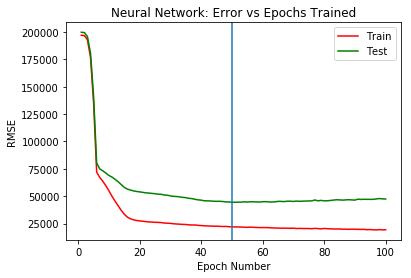

In [105]:
train_line = plt.plot(epochs,train_error, color='red', label='Train')
test_line = plt.plot(epochs,test_error, color='green', label='Test')
plt.title('Neural Network: Error vs Epochs Trained')
plt.ylabel('RMSE')
plt.xlabel('Epoch Number')
model_idx = np.argmin(test_error)
plt.axvline(x=model_idx)
plt.legend()

In [170]:
# PCA Tuning
def PCANN(X,y,k,f):
    n, d = X.shape
    z = np.zeros((k, 1))
    totalMSE = 0
    for i in range(k):
        T = list(range(int((i * n) / k), int((n * (i + 1) / k))))
        S = [j for j in range(n) if j not in T]

        training_mu, training_Z = pca(f, X[S])
        training_X = pca_proj(X[S], training_mu, training_Z)
        test_X = pca_proj(X[T], training_mu, training_Z)
        curr_model = NeuralNet(training_X, y[S], test_X, y[T])


        test_pred = curr_model.predict(test_X)
        testSE = 0
        for i in range(len(test_pred)):
            testSE += (test_pred[i]-y[T][i])**2
            
        totalMSE += testSE / n
        print(nnRMSE(curr_model, training_X, y[S], test_X, y[T]))
    
    return np.sqrt(totalMSE)

In [154]:
PCANN(kaggle_train_X_processed.values, kaggle_train_y.values.ravel(),5,50)

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [197884.5423145701, 196368.7558922504]
(Train, test): [53642.942794972434, 46764.75865150105]
(Train, test): [33592.3807148364, 26738.501051410163]
(Train, test): [31986.599150390506, 24724.30308937568]
(Train, test): [30278.027456117532, 25757.577359547096]
(Train, test): [29034.753313053156, 25662.115080011303]
(Train, test): [28235.457700395815, 26389.271760384305]
(Train, test): [27269.59916000672, 26916.9781498753]
(Train, test): [26460.05351513796, 27930.46248904474]
(Train, test): [25733.17115277814, 29866.13852725656]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [32192.63149083544, 24583.04385653187]
[32192.63149083544, 24583.04385653187]
(Train, test): [196941.77995472908, 200126.05054694906]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [47024.559043276124, 53058.58599882492]
(Train, test): [30725.999299519823, 34898.71883281797]
(Train, test): [28675.667742472477, 35988.867581932995]
(Train, test): [27125.815376747058, 37018.83062411032]
(Train, test): [26302.328809341874, 38811.13427882708]
(Train, test): [25532.124160044452, 39842.317877720234]
(Train, test): [24241.115459928566, 40680.56823108942]
(Train, test): [23178.10742499687, 42320.02759620249]
(Train, test): [22001.384530916977, 45386.5040955922]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [30822.795956649657, 34897.02186719866]
[30822.795956649657, 34897.02186719866]
(Train, test): [195926.288416514, 204073.17012156843]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [52071.67816160626, 59851.12982476003]
(Train, test): [31910.23077061433, 33644.7935065587]
(Train, test): [31990.852252147044, 32789.13419639343]
(Train, test): [30719.016052669456, 32089.0303913313]
(Train, test): [29646.543966931913, 32632.33292080565]
(Train, test): [28490.12892950563, 31303.53723469338]
(Train, test): [27637.847453932074, 29890.277810219628]
(Train, test): [26735.609861361037, 30080.044801479446]
(Train, test): [25683.457626482053, 29182.040755483784]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [26133.379189717896, 28438.233363448766]
[26133.379189717896, 28438.233363448766]
(Train, test): [200109.53326074415, 187134.1502016508]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [53381.830296868946, 45445.64189720608]
(Train, test): [33242.65103938732, 24739.87917383662]
(Train, test): [31287.781807865053, 23572.73857932773]
(Train, test): [30185.07639422056, 23729.333079977125]
(Train, test): [29230.84371193379, 24257.213954452392]
(Train, test): [28500.53295957571, 24218.123165493966]
(Train, test): [28148.69976168341, 24576.063519671283]
(Train, test): [27898.737300833352, 24712.78226396785]
(Train, test): [27366.125193320437, 25171.859034570272]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [31360.425178276568, 23041.742321576523]
[31360.425178276568, 23041.742321576523]
(Train, test): [197024.5580473739, 199794.3597533664]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [47280.74756621325, 56714.86972916163]
(Train, test): [27063.00431635981, 48265.6746928446]
(Train, test): [26164.899955551373, 47465.315181717924]
(Train, test): [24669.31301855518, 45452.20896559848]
(Train, test): [23364.265146834783, 45860.07189971143]
(Train, test): [22276.40421065797, 46245.87946637407]
(Train, test): [21760.291708020482, 47104.697894028184]
(Train, test): [21484.670247697097, 46668.11774848017]
(Train, test): [21326.666583942675, 46303.13878350637]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [21029.889282990658, 45256.3160663985]
[21029.889282990658, 45256.3160663985]


32279.768680712605

# Scatter Plots of predictions for all 4 models.

In [107]:
def plotScatter(predicted, name):
    colors = ["r", "b"]
    plt.title(name + " Predicted vs Actual Sale Price")
    plt.xlabel("Actual Sale Price")
    plt.ylabel("Predicted Sale Price")
    red_patch = mpatches.Patch(color='red', label='Actual Sale Price')
    blue_patch = mpatches.Patch(color='blue', label='Predicted Sale Price')
    plt.scatter(predicted['SalePrice'], predicted['predicted'], color="r", alpha=0.5)
    plt.show()


========== Prediction Scatter Plots Across Models ==========



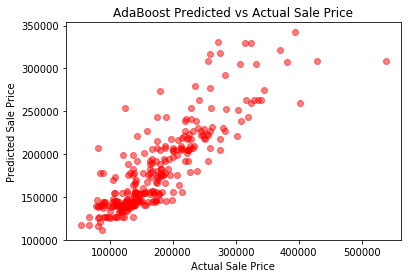

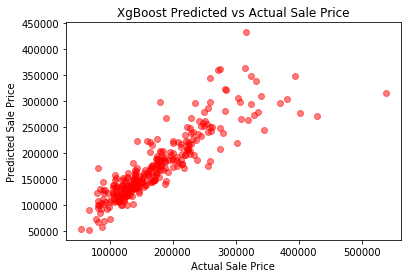

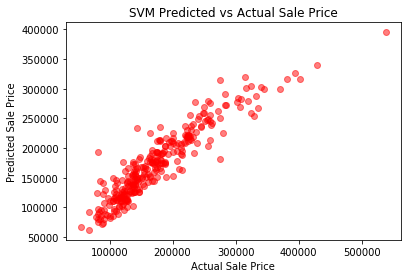

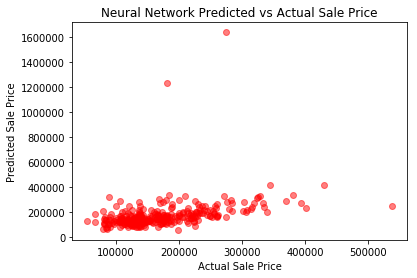

In [111]:
print()
print("========== Prediction Scatter Plots Across Models ==========")
print()

plotScatter(ada_pred, "AdaBoost")
plotScatter(xgb_pred, "XgBoost")
plotScatter(svr_pred, "SVM")
plotScatter(nn_pred, "Neural Network")

# Kaggle Submission

In [58]:
kaggle_xgb = XGBRegressor(max_depth=3, learning_rate=0.2, booster='gbtree', n_estimators=70)

kaggle_xgb.fit(X_kaggle_train_pca, kaggle_train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=70,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [59]:
kaggle_predicted = kaggle_xgb.predict(X_kaggle_test_pca)

In [60]:
kaggle_predicted_complete = pd.DataFrame({'Id': kaggle_test["Id"], 'SalePrice': kaggle_predicted})

In [61]:
kaggle_predicted_complete.to_csv('kaggle_predicted.csv', index=False)

# Kaggle Submission 2

In [87]:
kaggle_svr = svm.SVR(kernel="poly", coef0=-2500, gamma="auto")
kaggle_svr.fit(X_kaggle_train_pca, kaggle_train_y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=-2500, degree=3, epsilon=0.1, gamma='auto',
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [88]:
kaggle_svr_predicted = kaggle_svr.predict(X_kaggle_test_pca)

In [89]:
kaggle_svr_predicted_complete = pd.DataFrame({'Id': kaggle_test["Id"], 'SalePrice': kaggle_svr_predicted})

In [94]:
kaggle_svr_predicted_complete.to_csv('kaggle_svr_predicted.csv', index=False)

# Kaggle Submission 3

In [78]:
kaggle_nn = MLPRegressor(
                    hidden_layer_sizes=(48,48,48,),
                    activation='relu',
                    solver='sgd',
                    learning_rate='adaptive',
                    warm_start=True,
                    max_iter=1000,
                    learning_rate_init=0.01,
                    alpha=0.01)

kaggle_nn.fit(X_kaggle_train_pca, kaggle_train_y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_base.py:194: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(48, 48, 48), learning_rate='adaptive',
       learning_rate_init=0.01, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='sgd', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=True)

In [79]:
kaggle_nn_predicted = nn.predict(X_kaggle_test_pca)

In [80]:
kaggle_nn_predicted_complete = pd.DataFrame({'Id': kaggle_test["Id"], 'SalePrice': kaggle_nn_predicted})

In [81]:
kaggle_nn_predicted_complete.to_csv('kaggle_nn_predicted.csv', index=False)

# Comparing Submissions

In [90]:
submissions_df = pd.DataFrame({'SalePriceXGB': kaggle_predicted, 'SalePriceNN': kaggle_nn_predicted, 'SalePriceSVR': kaggle_svr_predicted})

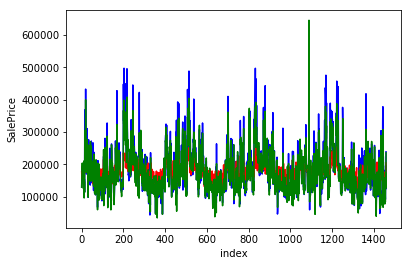

In [93]:
plt.plot(submissions_df.index, submissions_df["SalePriceXGB"], color='b')
plt.plot(submissions_df.index, submissions_df["SalePriceNN"], color='r')
plt.plot(submissions_df.index, submissions_df["SalePriceSVR"], color='green')
plt.xlabel("index")
plt.ylabel("SalePrice")
plt.show()

# Tuning Hyperparameters

## Tunes AdaBoost/XGBoost n_estimators and SVR's C parameters.

In [ ]:
#This takes time (~2mins)
def tune_hyperparameters(X, Y, f):
    adaboost_param_tuning = pd.DataFrame(columns=['parameter', 'rmse'])
    xgb_param_tuning = pd.DataFrame(columns=['parameter', 'rmse'])    
    svr_param_tuning = pd.DataFrame(columns=['parameter', 'rmse'])    

    #Tuning n estimators parameter for boosting algorithms
    for i in range(25,200,25):
        print("Boosting: " + str(i))
        print()
        adaBoost = AdaBoostRegressor(n_estimators=i)
        print(adaBoost)
        k_fold_z, k_fold_mse, k_fold_rmse, bootstrapping_z, bootstrapping_mse, bootstrapping_rmse = evaluate_model(adaBoost, f, X, Y.values.ravel(), k=5, B=5)
        adaboost_param_tuning = adaboost_param_tuning.append({'parameter': i, 'rmse': k_fold_rmse}, ignore_index=True)
        print()
        
        xgb = XGBRegressor(max_depth=3, learning_rate=0.2, booster='gbtree', n_estimators=i)
        print(xgb)
        k_fold_z, k_fold_mse, k_fold_rmse, bootstrapping_z, bootstrapping_mse, bootstrapping_rmse = evaluate_model(xgb, f, X, Y.values.ravel(), k=5, B=5)
        xgb_param_tuning = xgb_param_tuning.append({'parameter': i, 'rmse': k_fold_rmse}, ignore_index=True)
        print()
        
    #for i in range(25,200,25):
    c_vals = [0.01, 0.1, 10, 100]
    for i in c_vals:
        print("C: " + str(i))
        print()
        svr_model = svm.SVR(kernel="poly", coef0=-2500, gamma="auto", C=i)
        print(svr_model)
        k_fold_z, k_fold_mse, k_fold_rmse, bootstrapping_z, bootstrapping_mse, bootstrapping_rmse = evaluate_model(svr_model, f, X, Y.values.ravel(), k=5, B=5)
        svr_param_tuning = svr_param_tuning.append({'parameter': i, 'rmse': k_fold_rmse}, ignore_index=True)
        print()

    return xgb_param_tuning, adaboost_param_tuning, svr_param_tuning

In [ ]:
print()
print("========== Hyper-Parameter Tuning ==========")
print()

xgb_params, adaboost_params, svm_params = tune_hyperparameters(kaggle_train_X_processed.values, kaggle_train_y, f)

print()
print("*** Hyper-parameter Tuning Complete! ***")
print()

### Plots how the changing of hyperparameters changes our models' root mean squared log errors.

In [171]:
def plot_param_tuning(xgb_params, adaboost_params, svm_params):
    plt.plot(adaboost_params['parameter'], adaboost_params['rmse'], marker='o', color='b')
    plt.title("Adaboost RMSE vs n_estimators")
    plt.xlabel("n_estimators")
    plt.ylabel("RMSE")
    plt.show()
    
    plt.plot(xgb_params['parameter'], xgb_params['rmse'], marker='o', color='b')
    plt.title("XgBoost RMSE vs n_estimators")
    plt.xlabel("n_estimators")
    plt.ylabel("RMSE")
    plt.show()
    
    plt.plot(svm_params['parameter'], svm_params['rmse'], marker='o', color='b')
    plt.title("SVM RMSE vs C")
    plt.xlabel("C")
    plt.ylabel("RMSE")
    plt.show()

In [172]:
print()
print("========== Parameter Tuning Plots ==========")
print()

plot_param_tuning(xgb_params, adaboost_params, svm_params)


========== Parameter Tuning Plots ==========



NameError: name 'xgb_params' is not defined

## Tunes how many features to use from PCA.

In [173]:
# This takes time to run (~5mins)
def pca_tuning(F, X, Y):
    
    pca_ada_frame = pd.DataFrame(columns=['pca', 'rmse'])
    pca_xg_frame = pd.DataFrame(columns=['pca', 'rmse'])
    pca_svr_frame = pd.DataFrame(columns=['pca', 'rmse'])
    pca_nn_frame = []
    for f in F:
        print("\nPCA %d" % f)

        # AdaBoost
        print("\n")
        from sklearn.ensemble import AdaBoostRegressor
        adaBoost = AdaBoostRegressor()
        k_z, k_mse, k_rmse, b_z, b_mse, b_rmse = evaluate_model(adaBoost, f, X.values, Y.values.ravel(), k=5, B=5)
        pca_ada_frame = pca_ada_frame.append({'pca': f, 'rmse': k_rmse}, ignore_index=True)


        # XGBoost Regressor
        print("\nXGBoost")
        from xgboost import XGBRegressor

        xgb = XGBRegressor(max_depth=3, learning_rate=0.2, booster='gbtree', n_estimators=70)

        k_z, k_mse, k_rmse, b_z, b_mse, b_rmse = evaluate_model(xgb, f, X.values, Y.values.ravel(), k=5, B=5)
        pca_xg_frame = pca_xg_frame.append({'pca': f, 'rmse': k_rmse}, ignore_index=True)

        
        # SVM (SVR)
        print("\nSVR")
        from sklearn import svm

        svr_model = svm.SVR(kernel="poly", coef0=-3500, gamma='auto')
        # coef0 only works with poly and sigmoid kernels
        # it just puts that value instead of the column of 1's

        # without it, this model breaks for some reason

        k_z, k_mse, k_rmse, b_z, b_mse, b_rmse = evaluate_model(svr_model, f, X.values, Y.values.ravel(), k=5, B=5)
        pca_svr_frame = pca_svr_frame.append({'pca': f, 'rmse': k_rmse}, ignore_index=True)
        
        pca_nn_frame.append(PCANN(X.values,Y.values.ravel(),5,f))

        
    return (pca_ada_frame, pca_xg_frame, pca_svr_frame,pca_nn_frame)

### Plots how different amounts of PCA features affects our models' performances.

In [177]:
def plot_pca_tuning(ada_data, xg_data, svr_data, pca_nn_data):
    plt.title("RMSE vs PCA Values across models")
    plt.xlabel("PCA Values")
    plt.ylabel("RMSE")
    plt.grid()
    plt.plot(ada_data['pca'], ada_data['rmse'], marker='o', color='r', label="Adaboost")
    plt.plot(xg_data['pca'], xg_data['rmse'], marker='o', color='g', label="XgBoost")
    plt.plot(svr_data['pca'], svr_data['rmse'], marker='o', color='b', label="SVR")
    plt.plot(svr_data['pca'], pca_nn_data, marker='o', color='black', label="Neural Net")
    plt.legend(loc='best')
    plt.show()

In [175]:
print()
print("========== PCA Tuning ==========")
print()

pca_ada_frame, pca_xg_frame, pca_svr_frame, pca_nn_frame = pca_tuning([30,35,40,45,50,55,60,65,70], kaggle_train_X_processed, kaggle_train_y)

print()
print("*** PCA Tuning Complete ***")
print()


========== PCA Tuning ==========


PCA 30


Evaluating K-fold with 5 folds.
K-fold mse:  1766293724.6159267
K-fold Square Root mse:  42027.29737463411
Time elapsed for k-fold:  1.530888051999682


Evaluating bootstrapping with 5 bootstraps.
Bootstrapping Mean Squared Error:  1814674923.70713
Bootstrapping Square Root Mean Squared Error:  42599.00144025831
Time elapsed for bootstrapping:  1.710538457000439

XGBoost
Evaluating K-fold with 5 folds.
K-fold mse:  1106301495.2430403
K-fold Square Root mse:  33261.110854014485
Time elapsed for k-fold:  1.2046190680002837


Evaluating bootstrapping with 5 bootstraps.
Bootstrapping Mean Squared Error:  1334950905.2494125
Bootstrapping Square Root Mean Squared Error:  36536.97996892207
Time elapsed for bootstrapping:  1.4045977790001416

SVR
Evaluating K-fold with 5 folds.
K-fold mse:  1377700382.3395252
K-fold Square Root mse:  37117.386523562316
Time elapsed for k-fold:  0.6488363009993918


Evaluating bootstrapping with 5 bootstraps.
Bootstr

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [61409.74299314294, 54985.157828009775]
(Train, test): [35240.12940520532, 28100.485167882256]
(Train, test): [32793.342970986436, 24636.272504491266]
(Train, test): [31123.157516001935, 24462.475623703165]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [30917.512727915186, 24007.675744978063]
[30917.512727915186, 24007.675744978063]
(Train, test): [196941.40179044017, 200125.6692219423]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [45532.52228693082, 50373.4630578383]
(Train, test): [30332.233510328755, 34236.84931549696]
(Train, test): [28316.121857920236, 34951.236390708014]
(Train, test): [27975.151409210728, 37008.553896351914]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [29970.369570550476, 33611.38654246055]
[29970.369570550476, 33611.38654246055]
(Train, test): [195926.6132780026, 204073.49197621123]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [52133.25117175967, 59890.385177632736]
(Train, test): [32159.531984777634, 31967.762288256923]
(Train, test): [30651.67339378432, 30305.656605417702]
(Train, test): [29514.206330441277, 30379.689659557112]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [29505.652620978803, 28861.691379926535]
[29505.652620978803, 28861.691379926535]
(Train, test): [200109.4329381972, 187134.0497659782]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [53774.90678179869, 44785.929057622336]
(Train, test): [34004.29358620942, 25802.386050739533]
(Train, test): [32295.976367969637, 24576.630099167785]
(Train, test): [30713.00837827089, 23363.18681816127]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [30425.882779092393, 23172.386343951384]
[30425.882779092393, 23172.386343951384]
(Train, test): [197026.13007557878, 199795.9351351618]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [53128.86569268666, 60771.35536044403]
(Train, test): [28130.223590135298, 49796.420503485795]
(Train, test): [26443.800699922274, 47666.81170151047]
(Train, test): [25589.486045195197, 43755.60779560423]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [25101.83633180572, 42228.88662692734]
[25101.83633180572, 42228.88662692734]

PCA 35


Evaluating K-fold with 5 folds.
K-fold mse:  1886219019.5395012
K-fold Square Root mse:  43430.62306183854
Time elapsed for k-fold:  1.7032988590008245


Evaluating bootstrapping with 5 bootstraps.
Bootstrapping Mean Squared Error:  2091818070.4020686
Bootstrapping Square Root Mean Squared Error:  45736.39765440724
Time elapsed for bootstrapping:  2.023502987000029

XGBoost
Evaluating K-fold with 5 folds.
K-fold mse:  1151476426.49412
K-fold Square Root mse:  33933.411654210664
Time elapsed for k-fold:  1.6611163810002836


Evaluating bootstrapping with 5 bootstraps.
Bootstrapping Mean Squared Error:  1150839336.4153056
Boo

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [45197.19054660024, 39161.96991802132]
(Train, test): [32730.204407219775, 25057.975552321164]
(Train, test): [30568.71477018023, 24539.227929503304]
(Train, test): [29241.618468240133, 25038.211167774065]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [30610.946115601, 24254.436003745883]
[30610.946115601, 24254.436003745883]
(Train, test): [196941.98446425766, 200126.25526342524]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [41256.502064023756, 47046.33899658533]
(Train, test): [31834.081533369743, 34859.616323508264]
(Train, test): [29286.601158115223, 35006.90995290276]
(Train, test): [27969.563962371394, 36756.02557647586]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [31533.430138142245, 34062.76021857937]
[31533.430138142245, 34062.76021857937]
(Train, test): [195925.95681971847, 204072.84985106686]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [47854.61844977661, 54918.79715439438]
(Train, test): [32880.16404170724, 33665.022945589175]
(Train, test): [31374.310173800375, 32659.77484077527]
(Train, test): [30013.642132393936, 31327.82462471268]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [29067.65710300746, 29529.86566455064]
[29067.65710300746, 29529.86566455064]
(Train, test): [200110.18449037205, 187134.80889656677]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [52803.664067812635, 43726.766394856226]
(Train, test): [33466.33136086976, 25587.183507905425]
(Train, test): [31790.402174417984, 23521.013563401815]
(Train, test): [30499.370745865526, 22381.31884933187]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [30499.370745865526, 22381.31884933187]
[30499.370745865526, 22381.31884933187]
(Train, test): [197024.8325157813, 199794.61093923668]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [45300.74300278568, 54077.23547037207]
(Train, test): [26323.655914188643, 48056.58066310526]
(Train, test): [25202.628897106813, 45266.64963739357]
(Train, test): [24451.85065559593, 44736.474942334775]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [23909.61927451756, 43302.80475444612]
[23909.61927451756, 43302.80475444612]

PCA 40


Evaluating K-fold with 5 folds.
K-fold mse:  1942259358.0277061
K-fold Square Root mse:  44071.07166870016
Time elapsed for k-fold:  1.8575382619992524


Evaluating bootstrapping with 5 bootstraps.
Bootstrapping Mean Squared Error:  2008139222.5885825
Bootstrapping Square Root Mean Squared Error:  44812.26642994731
Time elapsed for bootstrapping:  2.085747602999618

XGBoost
Evaluating K-fold with 5 folds.
K-fold mse:  1230195393.0068004
K-fold Square Root mse:  35074.14137233869
Time elapsed for k-fold:  1.6123494869998467


Evaluating bootstrapping with 5 bootstraps.
Bootstrapping Mean Squared Error:  1220863264.5733223
Boo

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [55407.274228665374, 48447.744793358586]
(Train, test): [33787.459785131956, 25987.29765688879]
(Train, test): [31693.20616160873, 24907.262889597674]
(Train, test): [30399.498735847585, 24606.70391517492]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [30399.498735847585, 24606.70391517492]
[30399.498735847585, 24606.70391517492]
(Train, test): [196940.352566863, 200124.6176836943]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [50518.579419577196, 55452.831198749]
(Train, test): [32422.566581856154, 35024.03506203918]
(Train, test): [31239.015009041443, 35127.56255825014]
(Train, test): [29427.052584261415, 35756.16243508529]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [32144.146742742458, 34756.16305217933]
[32144.146742742458, 34756.16305217933]
(Train, test): [195924.71635827643, 204071.61990422301]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [41898.25273979818, 47913.07664173379]
(Train, test): [31470.378866712967, 33048.93278732082]
(Train, test): [29682.360595788494, 31046.336893149764]
(Train, test): [29032.74612928174, 29446.455948620565]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [28162.426752152332, 29072.569907336943]
[28162.426752152332, 29072.569907336943]
(Train, test): [200109.43699328715, 187134.05018148685]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [56694.64909101541, 48317.3434802729]
(Train, test): [32978.720731636, 25811.185361709842]
(Train, test): [31447.383450789945, 24159.670828789447]
(Train, test): [30161.495790602334, 24048.063442988903]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [31187.64469768496, 23378.73013671539]
[31187.64469768496, 23378.73013671539]
(Train, test): [197025.20386824783, 199795.01171323084]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [47976.08791298912, 56422.028022381215]
(Train, test): [28039.54122967349, 49495.92831092052]
(Train, test): [25791.66286759169, 48582.82934259314]
(Train, test): [24865.96915570772, 44774.16833073777]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [24459.676017762875, 44645.57042572473]
[24459.676017762875, 44645.57042572473]

PCA 45


Evaluating K-fold with 5 folds.
K-fold mse:  1887904900.4934337
K-fold Square Root mse:  43450.02762362106
Time elapsed for k-fold:  1.9964812469997923


Evaluating bootstrapping with 5 bootstraps.
Bootstrapping Mean Squared Error:  2092205827.2183602
Bootstrapping Square Root Mean Squared Error:  45740.63649773973
Time elapsed for bootstrapping:  2.2577265520003493

XGBoost
Evaluating K-fold with 5 folds.
K-fold mse:  1221103682.6654124
K-fold Square Root mse:  34944.293992945575
Time elapsed for k-fold:  1.6805038960001184


Evaluating bootstrapping with 5 bootstraps.
Bootstrapping Mean Squared Error:  1238389516.6609597
B

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [54489.50993972713, 47178.57394627988]
(Train, test): [33796.62117224905, 26666.297659760217]
(Train, test): [33046.82751335618, 24885.41619092552]
(Train, test): [31276.374962183036, 24560.573070777347]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [30918.415083318276, 24421.99178107116]
[30918.415083318276, 24421.99178107116]
(Train, test): [196940.94160044516, 200125.2023541795]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [46597.007008314635, 52433.72690299657]
(Train, test): [31219.78655036972, 34884.82886864726]
(Train, test): [29366.564861238396, 35751.87988061424]
(Train, test): [27528.019798745816, 37464.6202824169]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [31469.80385691373, 34729.79479483828]
[31469.80385691373, 34729.79479483828]
(Train, test): [195926.41425956856, 204073.2938049538]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [49926.503478674094, 57281.61456872913]
(Train, test): [32048.590633621403, 33873.435604015336]
(Train, test): [31530.002267641317, 32863.680174232904]
(Train, test): [30783.778375638572, 30719.209292141048]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [30783.778375638572, 30719.209292141048]
[30783.778375638572, 30719.209292141048]
(Train, test): [200109.9202523792, 187134.53817829836]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [51911.75839885935, 43871.90309364579]
(Train, test): [33550.42493016584, 25238.76353110246]
(Train, test): [32622.407442076503, 25219.61114495235]
(Train, test): [31317.006082652253, 23175.26286881685]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [31317.006082652253, 23175.26286881685]
[31317.006082652253, 23175.26286881685]
(Train, test): [197026.33925576872, 199796.13691088586]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [50913.996357802, 59155.54961001746]
(Train, test): [28151.411897688267, 48685.69008955788]
(Train, test): [26455.242640591845, 48756.06918300924]
(Train, test): [25020.585856384372, 47983.80237059037]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [24128.671742071456, 44268.82028040439]
[24128.671742071456, 44268.82028040439]

PCA 50


Evaluating K-fold with 5 folds.
K-fold mse:  1919086342.7215257
K-fold Square Root mse:  43807.377720214274
Time elapsed for k-fold:  2.1660306650001075


Evaluating bootstrapping with 5 bootstraps.
Bootstrapping Mean Squared Error:  1997875124.513298
Bootstrapping Square Root Mean Squared Error:  44697.59640644336
Time elapsed for bootstrapping:  2.3611909410001317

XGBoost
Evaluating K-fold with 5 folds.
K-fold mse:  1214630433.6218991
K-fold Square Root mse:  34851.54851110491
Time elapsed for k-fold:  1.8092677470003764


Evaluating bootstrapping with 5 bootstraps.
Bootstrapping Mean Squared Error:  1220732768.3169663
Bo

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [47920.008797516835, 41730.595112923795]
(Train, test): [33227.46623421817, 25982.829037710093]
(Train, test): [31594.986269010908, 24938.923211319947]
(Train, test): [29698.362718604072, 24511.224926512492]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [29698.362718604072, 24511.224926512492]
[29698.362718604072, 24511.224926512492]
(Train, test): [196942.3752022793, 200126.6440951009]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [50957.5792168983, 56032.224667809794]
(Train, test): [31073.791401866092, 35103.36979650226]
(Train, test): [29403.857266883366, 35951.793856001954]
(Train, test): [27710.860639943992, 36521.56942699658]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [30710.88601866964, 34625.296654532445]
[30710.88601866964, 34625.296654532445]
(Train, test): [195926.1787385101, 204073.06315442754]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [49696.569574374895, 57104.919733426614]
(Train, test): [31716.320095832605, 33365.25194655771]
(Train, test): [30267.54281585117, 32197.670142304072]
(Train, test): [29036.86341282492, 30989.39851184112]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [28670.636942491972, 29384.60013259618]
[28670.636942491972, 29384.60013259618]
(Train, test): [200109.78240567064, 187134.4026863281]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [47931.87756475015, 39919.91414557807]
(Train, test): [33271.77283583418, 24519.235095199165]
(Train, test): [31232.88962087149, 24293.096286011536]
(Train, test): [29637.668689526505, 24161.127147941217]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [30274.917463033053, 23421.9195228794]
[30274.917463033053, 23421.9195228794]
(Train, test): [197025.63390834074, 199795.42400297406]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [44758.758771880355, 53910.774721903035]
(Train, test): [26495.709263997807, 49604.04435018384]
(Train, test): [24665.244172786344, 49404.334553387824]
(Train, test): [23105.864895803574, 45257.89174197134]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [22187.716948603786, 44474.556589287065]
[22187.716948603786, 44474.556589287065]

PCA 55


Evaluating K-fold with 5 folds.
K-fold mse:  1893895080.555861
K-fold Square Root mse:  43518.90486393082
Time elapsed for k-fold:  2.3128217980001864


Evaluating bootstrapping with 5 bootstraps.
Bootstrapping Mean Squared Error:  2005822671.7697377
Bootstrapping Square Root Mean Squared Error:  44786.41168669062
Time elapsed for bootstrapping:  2.588816243999645

XGBoost
Evaluating K-fold with 5 folds.
K-fold mse:  1161278404.6739438
K-fold Square Root mse:  34077.535190708026
Time elapsed for k-fold:  2.052976973999648


Evaluating bootstrapping with 5 bootstraps.
Bootstrapping Mean Squared Error:  1533000887.29574

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [47180.83013655298, 40467.818084790815]
(Train, test): [31694.244452668547, 25656.13061955332]
(Train, test): [29030.85878924734, 24480.971046072562]
(Train, test): [27209.0655353032, 25297.575160450102]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [28815.72759479423, 24293.04932046253]
[28815.72759479423, 24293.04932046253]
(Train, test): [196941.18854421919, 200125.45678542732]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [50713.536904437045, 56316.524494907215]
(Train, test): [30915.703122868013, 35003.29114624888]
(Train, test): [28645.185206935686, 35442.87865704052]
(Train, test): [26605.08383175688, 36290.390659696175]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [29218.040382261213, 34962.215686249445]
[29218.040382261213, 34962.215686249445]
(Train, test): [195925.00072797213, 204071.90342891376]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [41770.57081722266, 48486.35061677657]
(Train, test): [30913.913208025402, 33633.29705477497]
(Train, test): [29763.61756848664, 31125.828695225966]
(Train, test): [28077.949637023292, 31466.230397690448]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [27370.716147968018, 30286.633372266166]
[27370.716147968018, 30286.633372266166]
(Train, test): [200109.35498330812, 187133.96278563314]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [51202.02578032647, 43575.41466882629]
(Train, test): [32045.145953043044, 25311.726685381018]
(Train, test): [30183.925146806778, 23633.41615264356]
(Train, test): [27885.794049725275, 24258.125789821755]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [29898.756119116097, 23409.639967326995]
[29898.756119116097, 23409.639967326995]
(Train, test): [197025.49009151326, 199795.28643806704]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [49188.3337983572, 58108.89226372168]
(Train, test): [26667.870412597513, 50647.69260863036]
(Train, test): [24902.361280831214, 47856.30997191663]
(Train, test): [23281.301406920935, 43961.96502310314]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [22015.313488323136, 43391.023895895596]
[22015.313488323136, 43391.023895895596]

PCA 60


Evaluating K-fold with 5 folds.
K-fold mse:  1932330295.0560176
K-fold Square Root mse:  43958.27902745987
Time elapsed for k-fold:  2.6601429970005483


Evaluating bootstrapping with 5 bootstraps.
Bootstrapping Mean Squared Error:  1826318432.3467133
Bootstrapping Square Root Mean Squared Error:  42735.44702406555
Time elapsed for bootstrapping:  2.9521439299996928

XGBoost
Evaluating K-fold with 5 folds.
K-fold mse:  1170035996.5661383
K-fold Square Root mse:  34205.78893354366
Time elapsed for k-fold:  2.232560270999784


Evaluating bootstrapping with 5 bootstraps.
Bootstrapping Mean Squared Error:  1323237974.5941389


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [47645.78870266621, 41372.288961185644]
(Train, test): [32821.630960603725, 25720.76737168501]
(Train, test): [29981.348363511515, 25392.346736897503]
(Train, test): [27259.59909854571, 26017.350029641584]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [31688.721201671535, 25141.41741636649]
[31688.721201671535, 25141.41741636649]
(Train, test): [196941.94676638258, 200126.21792487358]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [46519.78371476747, 53073.235824099305]
(Train, test): [30067.201956447847, 34774.26505160815]
(Train, test): [28138.795019233614, 35120.253592293106]
(Train, test): [26173.486545699518, 36339.3878033734]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [29843.384250018255, 34550.65165878499]
[29843.384250018255, 34550.65165878499]
(Train, test): [195927.46954752647, 204074.3343127867]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [45316.705777939664, 53412.37464250045]
(Train, test): [31101.87767368909, 34863.87061367847]
(Train, test): [29622.393880805823, 33907.35910992842]
(Train, test): [28106.36170217444, 31556.487258933736]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [29468.445715734528, 30992.858297944564]
[29468.445715734528, 30992.858297944564]
(Train, test): [200109.86708669597, 187134.48937270703]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [52562.93375693065, 44794.49793027446]
(Train, test): [31670.22271945406, 25247.242852429437]
(Train, test): [30019.244760774043, 23869.98385215011]
(Train, test): [28048.679396912627, 24730.22484525706]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [28427.874776579672, 23813.098616470033]
[28427.874776579672, 23813.098616470033]
(Train, test): [197025.19379682705, 199795.00982022152]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [47406.830325236035, 57278.46823028117]
(Train, test): [27429.71597909563, 48944.326534545165]
(Train, test): [25166.250715961134, 48080.77408426429]
(Train, test): [23322.670915271723, 46588.858875075966]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [22360.69893098831, 45722.44972566824]
[22360.69893098831, 45722.44972566824]

PCA 65


Evaluating K-fold with 5 folds.
K-fold mse:  1876948805.0967948
K-fold Square Root mse:  43323.767208044075
Time elapsed for k-fold:  2.744992658999763


Evaluating bootstrapping with 5 bootstraps.
Bootstrapping Mean Squared Error:  1949579230.384219
Bootstrapping Square Root Mean Squared Error:  44154.03979687724
Time elapsed for bootstrapping:  2.940525302000424

XGBoost
Evaluating K-fold with 5 folds.
K-fold mse:  1196472237.124458
K-fold Square Root mse:  34590.05980226773
Time elapsed for k-fold:  2.2813957239995943


Evaluating bootstrapping with 5 bootstraps.
Bootstrapping Mean Squared Error:  1187245538.2470727
Boo

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [42134.843121139944, 36094.85197549376]
(Train, test): [29705.284871236283, 24963.30834481081]
(Train, test): [26501.303575554193, 26647.39332200097]
(Train, test): [23593.817483909006, 28675.070009925286]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [31300.24948256077, 24579.822656520668]
[31300.24948256077, 24579.822656520668]
(Train, test): [196941.96915658296, 200126.23970030312]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [44633.06013988039, 51784.96634183043]
(Train, test): [28781.530146202524, 35329.8893484579]
(Train, test): [25003.86265756908, 35807.155587333655]
(Train, test): [22761.331538236467, 36763.89137491784]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [29090.703747872878, 35274.078537656766]
[29090.703747872878, 35274.078537656766]
(Train, test): [195926.31132392332, 204073.19154322456]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [52851.175902211566, 61617.761990150684]
(Train, test): [30435.954708932422, 33774.07545172386]
(Train, test): [29495.99642362849, 32761.10623601175]
(Train, test): [28150.80218950272, 32867.61817682636]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [27334.700472843448, 30022.29994067671]
[27334.700472843448, 30022.29994067671]
(Train, test): [200108.53591896986, 187133.1457073022]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [46441.87420686999, 39355.201048304705]
(Train, test): [30485.23649302955, 23790.877594790476]
(Train, test): [28050.78172114533, 23117.773576659456]
(Train, test): [25646.27111905198, 24059.034279524196]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [27996.082705084293, 22963.266435587208]
[27996.082705084293, 22963.266435587208]
(Train, test): [197023.58007613954, 199793.39730142834]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [38690.49697864709, 50152.142260118795]
(Train, test): [26011.66756914355, 49110.5052324045]
(Train, test): [23651.091983322283, 48081.07227306108]
(Train, test): [21666.129091634142, 48450.9996127194]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [21328.678927202975, 47244.74148806101]
[21328.678927202975, 47244.74148806101]

PCA 70


Evaluating K-fold with 5 folds.
K-fold mse:  1927327173.3812683
K-fold Square Root mse:  43901.334528477244
Time elapsed for k-fold:  2.9878425590004554


Evaluating bootstrapping with 5 bootstraps.
Bootstrapping Mean Squared Error:  1713816209.2555501
Bootstrapping Square Root Mean Squared Error:  41398.26336038204
Time elapsed for bootstrapping:  3.26693549599986

XGBoost
Evaluating K-fold with 5 folds.
K-fold mse:  1202299559.5909705
K-fold Square Root mse:  34674.19154920516
Time elapsed for k-fold:  2.534117000000151


Evaluating bootstrapping with 5 bootstraps.
Bootstrapping Mean Squared Error:  1247984174.6550088
Boot

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [50633.51711344161, 43104.295331559544]
(Train, test): [31615.562992873445, 24077.00562513757]
(Train, test): [29082.21534614847, 23311.149548350662]
(Train, test): [25748.725494518927, 24402.050412699726]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [27919.117744168776, 22943.553111108104]
[27919.117744168776, 22943.553111108104]
(Train, test): [196941.47835934328, 200125.75305002517]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [43246.96734261812, 49546.428229923236]
(Train, test): [28232.1552957788, 34805.5346731539]
(Train, test): [26397.569883854118, 35109.486360740186]
(Train, test): [24087.846030575754, 36190.893891864245]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [28428.101627300544, 34746.368453918134]
[28428.101627300544, 34746.368453918134]
(Train, test): [195925.83789511674, 204072.72829161494]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [47116.927949242374, 55108.38808095228]
(Train, test): [29544.19949456787, 33732.47183682617]
(Train, test): [28092.576558762386, 32482.848138318983]
(Train, test): [26696.620307403664, 32392.552935077794]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [26063.26828259803, 30962.936436741067]
[26063.26828259803, 30962.936436741067]
(Train, test): [200109.12809640437, 187133.74057630368]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [48121.69035049539, 42596.51964424511]
(Train, test): [31582.33101150689, 24853.74465012833]
(Train, test): [29320.100368045347, 24467.7650790938]
(Train, test): [27022.488494834062, 23395.04944943136]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [28012.077172553327, 23090.656127713486]
[28012.077172553327, 23090.656127713486]
(Train, test): [197024.68925277083, 199794.48980586953]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [45260.16645982379, 54908.88265572447]
(Train, test): [26455.174478658773, 47737.65473178485]
(Train, test): [24563.56474812688, 47045.30348877623]
(Train, test): [22488.73983364909, 44537.643586534934]
Loaded nn with weights of lowest model.
RMSE: (Train, test): [21413.936779185595, 43524.9914553032]
[21413.936779185595, 43524.9914553032]

*** PCA Tuning Complete ***



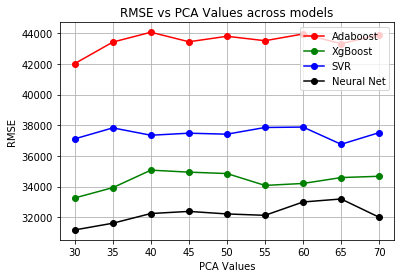

In [178]:
plot_pca_tuning(pca_ada_frame, pca_xg_frame, pca_svr_frame, pca_nn_frame)

# Learning Curves

In [112]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()


========== Learning Curves ==========



/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


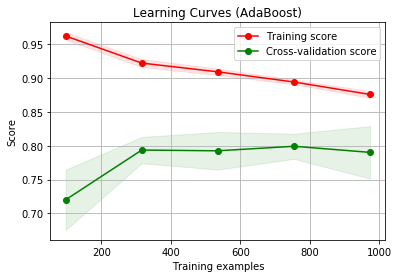

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


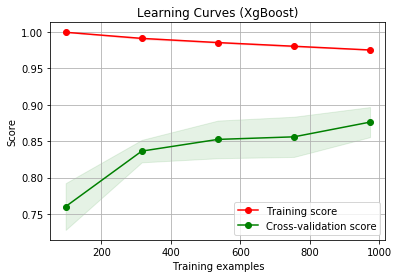

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


KeyboardInterrupt: 

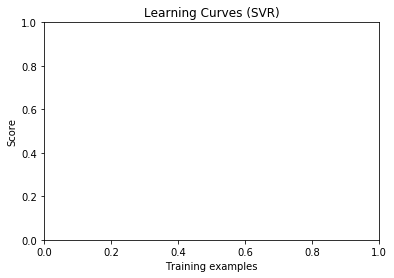

In [113]:
print()
print("========== Learning Curves ==========")
print()
plot_learning_curve(estimator=adaBoost, title="Learning Curves (AdaBoost)", X=kaggle_train_X_processed, y=kaggle_train_y.values.ravel(), ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5))
plot_learning_curve(estimator=xgb, title="Learning Curves (XgBoost)", X=kaggle_train_X_processed, y=kaggle_train_y.values.ravel(), ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5))
plot_learning_curve(estimator=svr_model, title="Learning Curves (SVR)", X=kaggle_train_X_processed, y=kaggle_train_y.values.ravel(), ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5))